<H1>10,000 USD worth of TKN invested in the Omnipool for 4 months</H1>

In [1]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price, value_assets
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices, ArchiveState

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.17},
    'TKN': {'usd price': 1, 'weight': 0.03}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0.0025,
            lrna_fee=0.0005
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = len(price_list)-1

# copy DOT prices for TKN
# for j, step in enumerate(price_list):     
#     step['TKN'] = step['DOT'] / price_list[0]['DOT']

In [2]:
volume_events = []
trade_volume = []
semi_final_state = []
final_state = []
# initial_state._evolve_function = historical_prices(price_list)
for i in range(5):
    initial_state.agents['Trader'].trade_strategy=price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=12 * i + 3,
        price_sensitivity=20
    ) if i > 0 else None
    events = run.run(initial_state, time_steps)
    
    # arbitrage
#     omnipool=events[-1].pools['omnipool']
#     semi_final_state.append(GlobalState(
#         pools={
#             'omnipool': OmnipoolState(
#                 tokens={
#                     tkn:{
#                         'liquidity': omnipool.liquidity[tkn],
#                         'LRNA': omnipool.lrna[tkn]
#                     } for tkn in omnipool.asset_list
#                 },
#                 asset_fee = initial_state.pools['omnipool'].asset_fee,
#                 lrna_fee = initial_state.pools['omnipool'].lrna_fee
#             )
#         },
#         agents={
#             'Trader': Agent(
#                 holdings=events[-1].agents['Trader'].holdings
#             ),
#             'LP': Agent(
#                 holdings=events[-1].agents['LP'].holdings,
#                 share_prices=events[-1].agents['LP'].share_prices
#             ),
#             'Arbitrageur': Agent(
#                 holdings={tkn: float('inf') for tkn in assets},
#                 trade_strategy=omnipool_arbitrage('omnipool')
#             )
#         },
#         external_market=events[-1].external_market,
#         archive_all=True
#     ))
#     semi_final_state[-1].pools['omnipool'].shares = {tkn: events[-1].pools['omnipool'].shares[tkn] for tkn in assets}
#     semi_final_state[-1].pools['omnipool'].protocol_shares = {tkn: events[-1].pools['omnipool'].protocol_shares[tkn] for tkn in assets}
#     final_state.append(run.run(semi_final_state[-1], 1, silent=True)[-1])
#     events.append(ArchiveState(final_state[-1]))

    trade_volume.append((sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
        / time_steps / 10000000 * 7200)
        # if i > 0 else 0
    )
    print('Trade volume per day as a fraction of TVL:', trade_volume[i])

    volume_events.append(events[::200])
    volume_events[-1].append(events[-1])
    
    del events
    

Starting simulation...
Execution time: 77.443 seconds.
Trade volume per day as a fraction of TVL: 0.0
Starting simulation...
Execution time: 105.568 seconds.
Trade volume per day as a fraction of TVL: 0.005900556826722759
Starting simulation...
Execution time: 93.002 seconds.
Trade volume per day as a fraction of TVL: 0.010660951145895117
Starting simulation...
Execution time: 102.641 seconds.
Trade volume per day as a fraction of TVL: 0.015492768695438001
Starting simulation...
Execution time: 85.842 seconds.
Trade volume per day as a fraction of TVL: 0.02035746278527638


<H3>Effects of trade volume.</H3>
Trade volume generates fees, which are the primary way of offsetting IL. We'll assume the middle price path for this example (minimum impermanent loss). Trade volume goes from 0.03% to 2% of TVL per day. (So far we have observed ~1% on average.) We also assume 0.3% total fees.

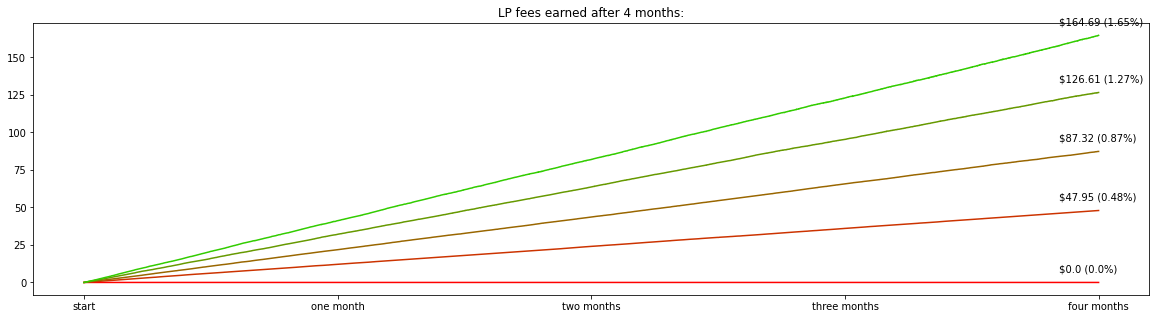

In [3]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after 4 months:')
graph_length = len(volume_events[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)
colors = pu.color_gradient(length=5, color1=(255, 0, 0), color2=(0, 255, 0))
baseline =[value_assets(event.external_market, initial_state.agents['LP'].holdings) for event in volume_events[0]]
# [0] * len(volume_events[0])
# [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in volume_events[0]]
volume_returns = [
    [
        cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline[i]
        for i, event in enumerate(events)
    ]
    for events in volume_events
]
for i, scenario in enumerate(volume_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, 10), textcoords='offset points'
    )

<AxesSubplot:title={'center':'omnipool  lrna_price USD '}>

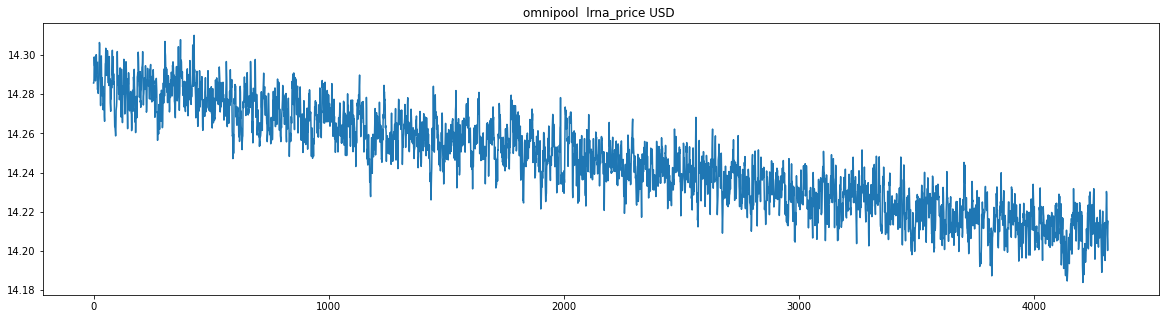

In [4]:
pu.plot(volume_events[3], pool='omnipool', prop='lrna_price', key='USD')